## Anomaly Detection
### Laboratory 2

### Ex. 1

In [109]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [118]:
def compute_leverage_scores(X):
    X = np.column_stack((np.ones(len(X)), X))
    H = X @ np.linalg.inv(X.T @ X) @ X.T
    return np.diag(H)

In [119]:
def generate_data_1d(n, a, b, mu, sigma):
    x = np.linspace(0, 10, n)
    eps = np.random.normal(mu, sigma, n)
    y = a * x + b + eps
    return x, y

In [120]:
def add_high_variance_points(x, y, num_extra):
    rng = np.random.default_rng(42)

    x_highx = rng.uniform(-20, 30, num_extra)
    y_highx = 2 * x_highx + 1 + rng.normal(0, 1, num_extra)

    x_highy = rng.uniform(0, 10, num_extra)
    y_highy = 2 * x_highy + 1 + rng.normal(0, 20, num_extra)

    x_highxy = rng.uniform(-20, 30, num_extra)
    y_highxy = 2 * x_highxy + 1 + rng.normal(0, 20, num_extra)

    x_all = np.concatenate([x, x_highx, x_highy, x_highxy])
    y_all = np.concatenate([y, y_highx, y_highy, y_highxy])
    return x_all, y_all

In [121]:
def plot_leverage_1d(sigmas):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.flatten()

    for i, sigma in enumerate(sigmas):
        x, y = generate_data_1d(n=50, a=2.0, b=1.0, mu=0, sigma=sigma)
        x, y = add_high_variance_points(x, y, 5)

        X = x.reshape(-1, 1)
        model = LinearRegression().fit(X, y)
        y_pred = model.predict(X)
        h = compute_leverage_scores(X)

        high_lev_idx = np.argsort(h)[-5:]

        axes[i].scatter(x, y, alpha=0.7, label=f"sigma={sigma}")
        axes[i].scatter(x[high_lev_idx], y[high_lev_idx], alpha=0.7, color="red", label="leverage")
        axes[i].set_title(f"sigma={sigma}")
        axes[i].legend()

    plt.suptitle("Unidimensional Leverage Scores")
    plt.tight_layout()
    plt.show()

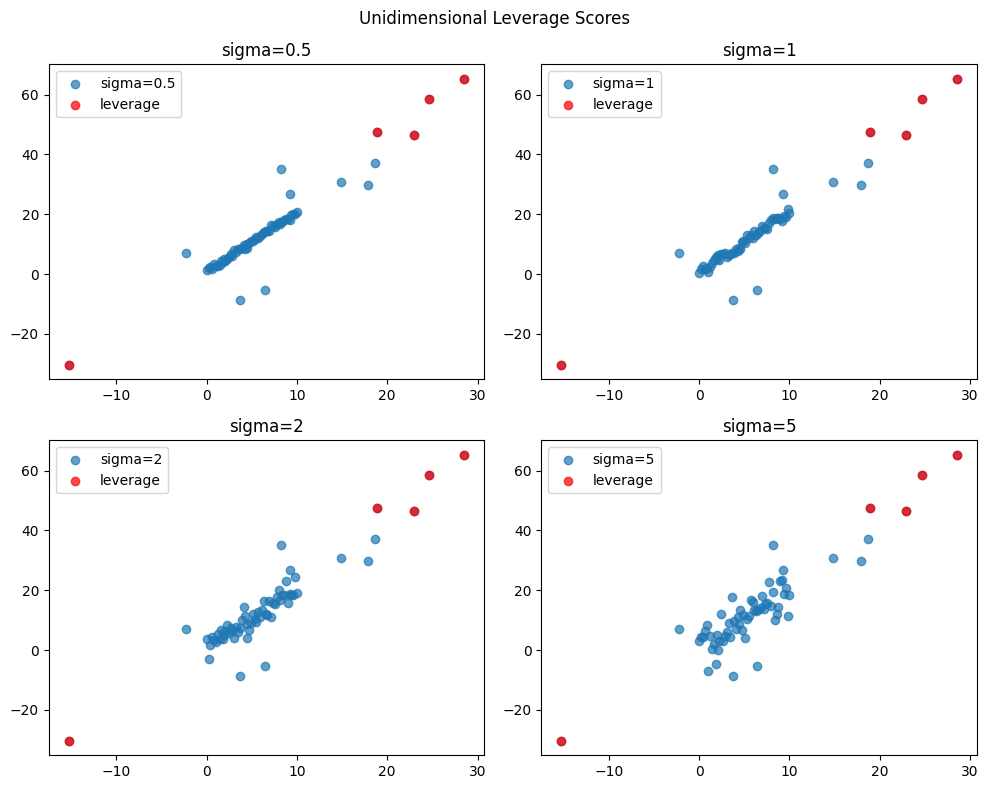

In [122]:
sigmas = [0.5, 1, 2, 5]
plot_leverage_1d(sigmas)

In [123]:
def generate_data_2d(n, a, b, c, mu, sigma):
    x1 = np.random.uniform(0, 10, n)
    x2 = np.random.uniform(0, 10, n)
    eps = np.random.normal(mu, sigma, n)
    y = a * x1 + b * x2 + c + eps
    return x1, x2, y

In [124]:
def plot_leverage_2d(sigmas):
    for sigma in sigmas:
        x1, x2, y = generate_data_2d(n=50, a=2.0, b=1.0, c=0.5, mu=0, sigma=sigma)

        X = np.column_stack((x1, x2))

        model = LinearRegression().fit(X, y)
        y_pred = model.predict(X)

        h = compute_leverage_scores(X)
        high_lev_idx = np.argsort(h)[-5:]

        fig = plt.figure(figsize=(7, 6))
        ax = fig.add_subplot(111, projection="3d")

        ax.scatter(x1, x2, y, alpha=0.7, label="points")

        ax.scatter(
            x1[high_lev_idx],
            x2[high_lev_idx],
            y[high_lev_idx],
            alpha=0.7,
            color="red",
            label="leverage"
        )

        ax.set_title(f"2D Leverage Scores (sigma = {sigma})")
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_zlabel("y")
        ax.legend()

        plt.show()

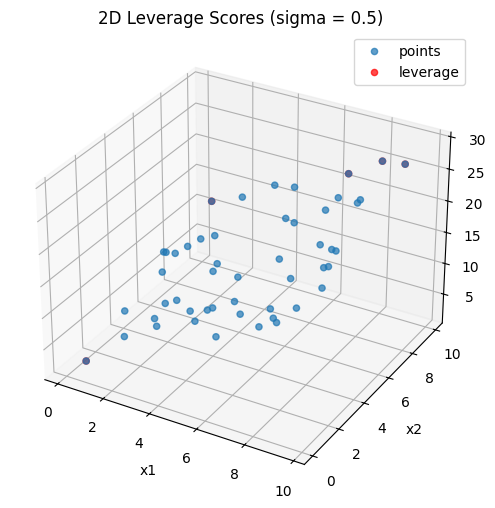

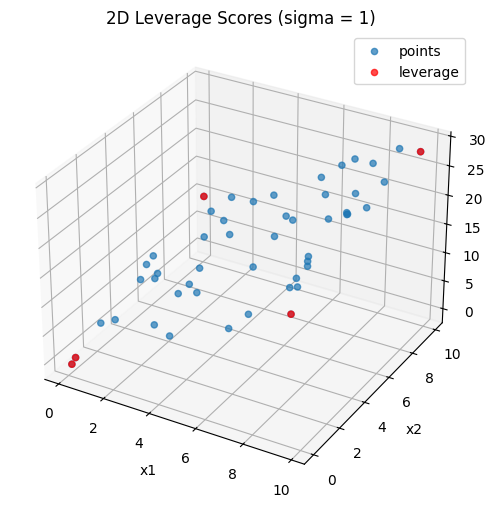

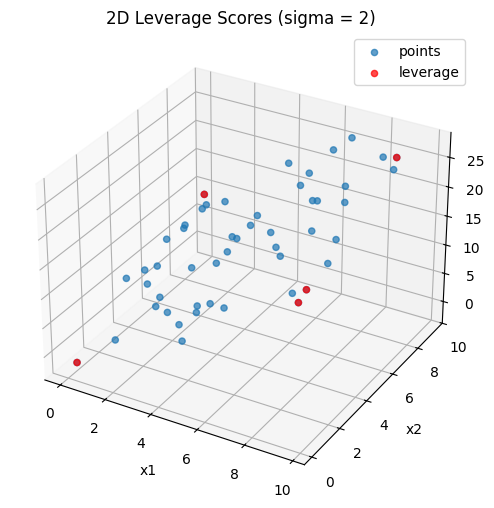

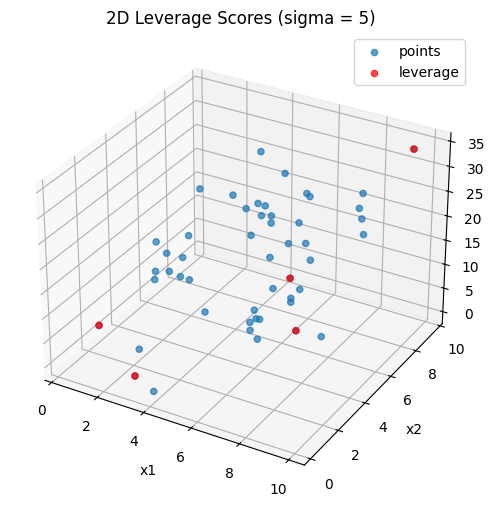

In [125]:
sigmas = [0.5, 1, 2, 5]
plot_leverage_2d(sigmas)

### Ex. 2

In [126]:
from pyod.utils.data import generate_data_clusters
from pyod.models.knn import KNN
from sklearn.metrics import balanced_accuracy_score

In [127]:
X_train, X_test, y_train, y_test = generate_data_clusters(n_train=400, n_test=200, n_clusters=2, n_features=2, contamination=0.1)

In [128]:
X_train[:5]

array([[-0.50053745,  0.82094411],
       [-2.34480327, -3.48816609],
       [-0.67466683,  1.09346092],
       [-2.45631459, -3.44397741],
       [-0.98979145,  0.54979887]])

In [129]:
X_test[:5]

array([[-2.99899281, -3.52289827],
       [-2.20865126, -3.21280048],
       [-0.64781234, -0.07706732],
       [-2.10882987, -2.99233545],
       [-0.7024472 ,  0.09976836]])

In [130]:
clf = KNN()
clf.fit(X_train)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [131]:
y_train_predict = clf.labels_

In [132]:
y_test_predict = clf.predict(X_test)

In [133]:
import matplotlib.pyplot as plt

In [140]:
def plot_truth(n, X_train_, y_train_, X_test_, y_test_, y_train_predict_, y_test_predict_, bal_acc_train, bal_acc_test):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
    fig.suptitle(f"Ground Truth for n = {n}")

    scatter_params = dict(cmap='coolwarm', alpha=0.7)

    ax1.scatter(X_train_[:, 0], X_train_[:, 1], c=y_train_, **scatter_params)
    ax1.set_title("Ground Truth (Train)")

    ax2.scatter(X_train_[:, 0], X_train_[:, 1], c=y_train_predict_, **scatter_params)
    ax2.set_title(f"Predictions (Train)\nBalanced Acc: {bal_acc_train:.2f}")

    ax3.scatter(X_test_[:, 0], X_test_[:, 1], c=y_test_, **scatter_params)
    ax3.set_title("Ground Truth (Test)")

    ax4.scatter(X_test_[:, 0], X_test_[:, 1], c=y_test_predict_, **scatter_params)
    ax4.set_title(f"Predictions (Test) \nBalanced Acc: {bal_acc_test:.2f}")

    plt.tight_layout()
    plt.show()

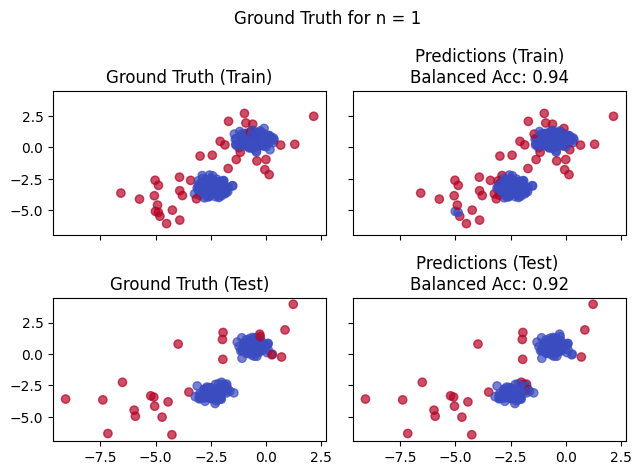

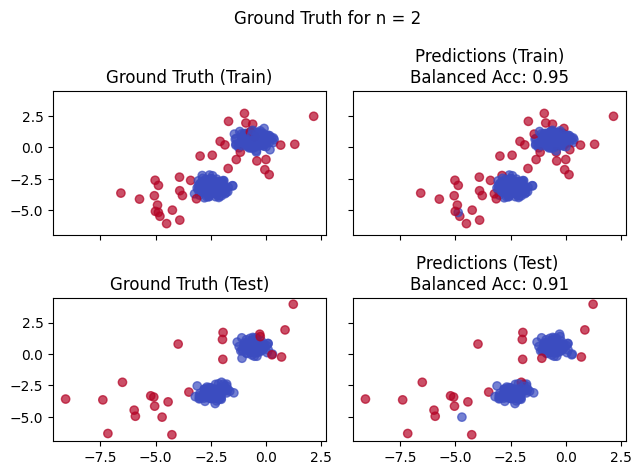

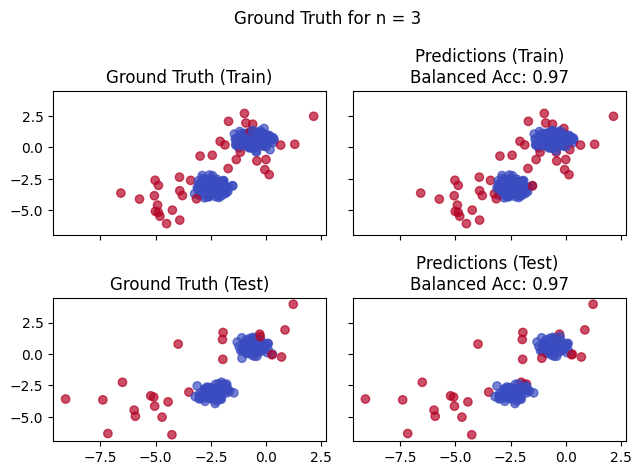

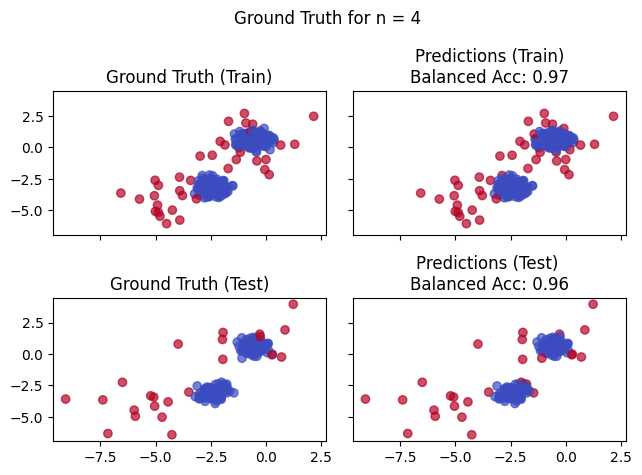

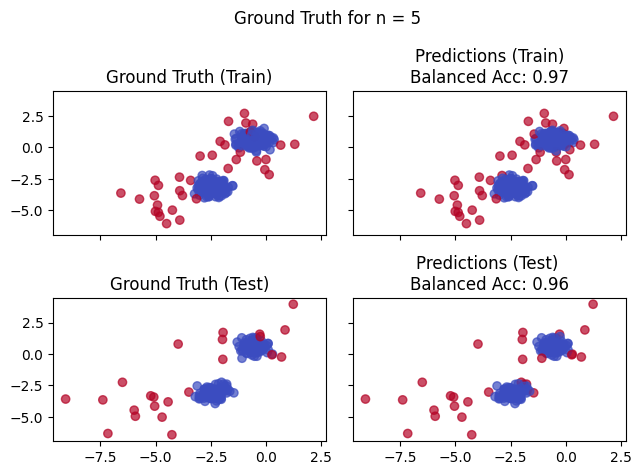

In [141]:
n_neigh_params = [1, 2, 3, 4, 5]
results = []

for neigh in n_neigh_params:
    knn = KNN(n_neighbors=neigh, n_jobs=-1)
    knn.fit(X_train)

    y_train_predict = knn.labels_
    y_test_predict = knn.predict(X_test)

    bal_acc_train = balanced_accuracy_score(y_train, y_train_predict)
    bal_acc_test = balanced_accuracy_score(y_test, y_test_predict)

    results.append((neigh, bal_acc_train, bal_acc_test))

    plot_truth(neigh, X_train, y_train, X_test, y_test, y_train_predict, y_test_predict, bal_acc_train, bal_acc_test)

### Ex. 3

In [142]:
from sklearn.datasets import make_blobs
from pyod.models.lof import LOF

In [143]:
X, y = make_blobs(n_samples=[200, 100], centers=[(-10, -10), (10, 10)], cluster_std=[2, 6], n_features=2)

In [144]:
X[:5]

array([[-11.13461388,  -8.48441098],
       [-11.7187808 , -10.33368296],
       [-10.54010556,  -7.77302277],
       [ 19.47427222,   9.97197386],
       [-11.1327299 , -12.39253681]])

In [145]:
X.shape

(300, 2)

In [146]:
contamination = 0.07
n_neighbors_list = [3, 5, 10]

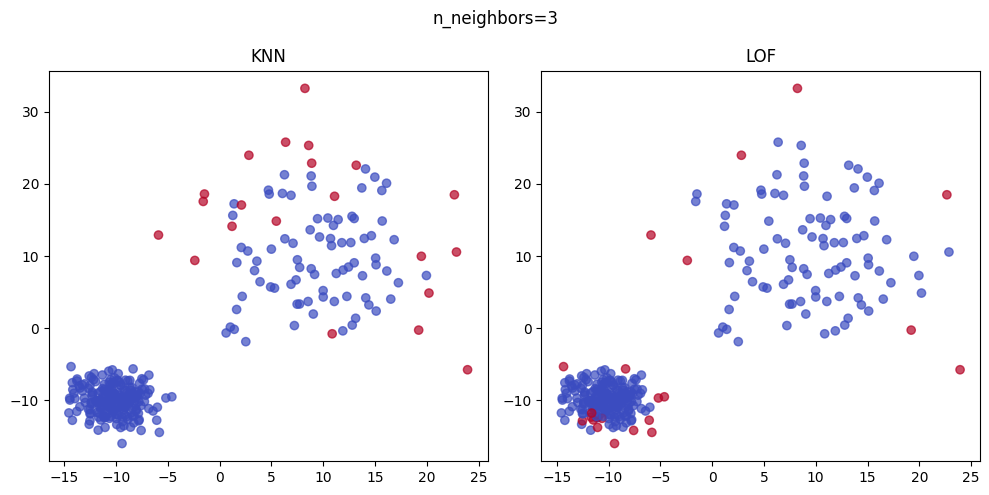

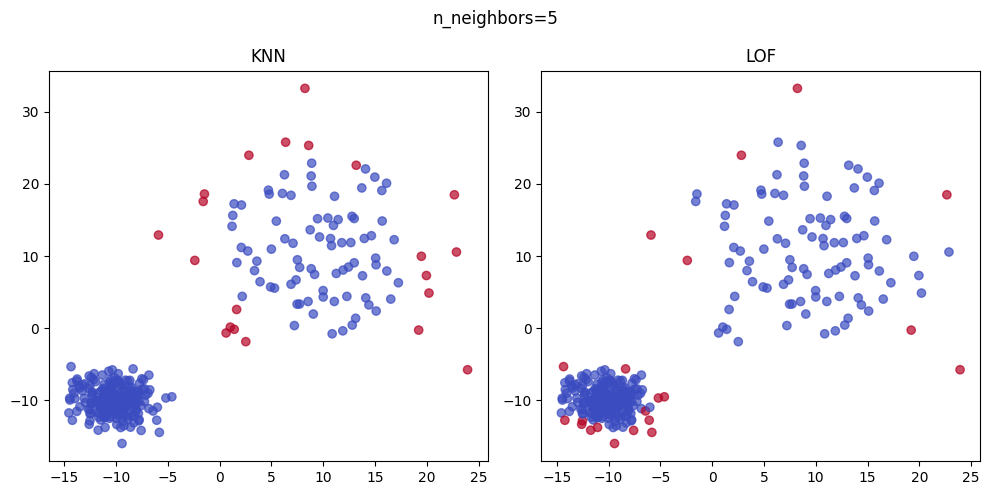

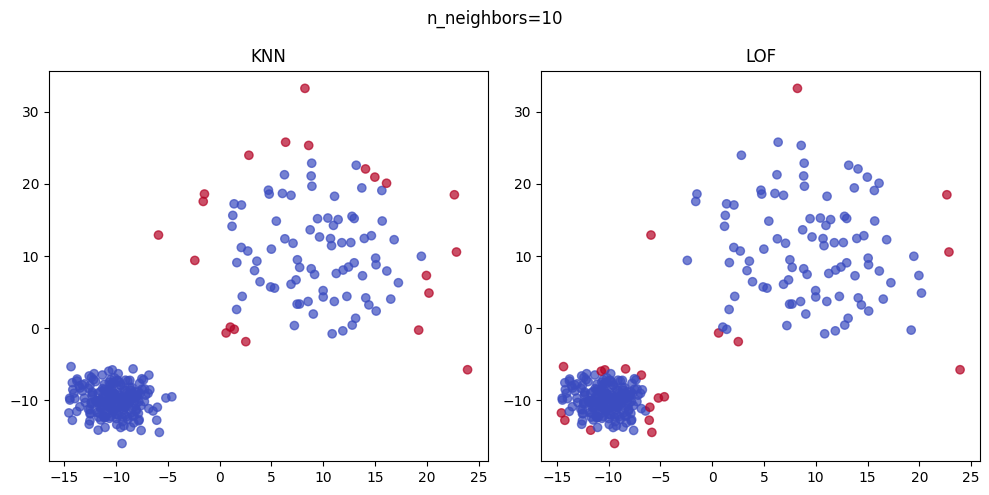

In [147]:
for n_neighbors in n_neighbors_list:
    knn = KNN(n_neighbors=n_neighbors, contamination=contamination)
    knn.fit(X)
    y_pred_knn = knn.labels_

    lof = LOF(n_neighbors=n_neighbors, contamination=contamination)
    lof.fit(X)
    y_pred_lof = lof.labels_

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f"n_neighbors={n_neighbors}")

    axes[0].scatter(X[:, 0], X[:, 1], c=y_pred_knn, cmap="coolwarm", alpha=0.7)
    axes[0].set_title("KNN")

    axes[1].scatter(X[:, 0], X[:, 1], c=y_pred_lof, cmap="coolwarm", alpha=0.7)
    axes[1].set_title("LOF")

    plt.tight_layout()
    plt.show()

### Ex. 4

In [149]:
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pyod.utils.utility import standardizer
from pyod.models.combination import average, maximization

In [150]:
data = loadmat("data/cardio.mat")

In [151]:
X = data['X']
y = data['y'].ravel()

In [152]:
X[:3]

array([[ 0.00491231,  0.69319077, -0.20364049,  0.59532212,  0.35318961,
        -0.06140064, -0.27829495, -1.65044442,  0.75907246, -0.42048735,
         0.37214916,  1.48597292, -0.79837645,  1.85472761,  0.62263103,
         0.96308254,  0.30146435,  0.19311344,  0.23149795, -0.28978574,
        -0.49329397],
       [ 0.11072935, -0.07990259, -0.20364049,  1.26894234,  0.39624557,
        -0.06140064, -0.27829495, -1.71026988,  0.75907246, -0.42048735,
         0.88279447,  1.48597292, -0.79837645,  1.85472761,  0.27862457,
         0.96308254,  0.30146435,  0.12926535,  0.09356344, -0.25638541,
        -0.49329397],
       [ 0.21654639, -0.27244466, -0.20364049,  1.05098837,  0.14875252,
        -0.06140064, -0.27829495, -1.71026988,  1.10650893, -0.42048735,
         2.51685946,  1.14178027, -1.33293055,  0.3146885 ,  2.34266335,
        -0.48827889,  0.06100204,  0.06541726,  0.02459619, -0.25638541,
         1.14001753]])

In [153]:
y[:3]

array([0., 0., 0.])

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [155]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [156]:
n_neighbors_list = np.linspace(30, 120, 10, dtype=int)
contamination = 0.1

In [157]:
train_scores_list = []
test_scores_list = []

In [158]:
for n in n_neighbors_list:
    clf = KNN(n_neighbors=n, contamination=contamination)
    clf.fit(X_train)

    train_scores = clf.decision_scores_
    test_scores = clf.decision_function(X_test)

    y_train_pred = clf.labels_
    y_test_pred = clf.predict(X_test)

    ba_train = balanced_accuracy_score(y_train, y_train_pred)
    ba_test = balanced_accuracy_score(y_test, y_test_pred)

    print(f"KNN (n_neighbors={n}): bal_acc Train={ba_train:.2f}, bal_acc Test={ba_test:.2f}")

    train_scores_list.append(train_scores)
    test_scores_list.append(test_scores)

KNN (n_neighbors=30): bal_acc Train=0.71, bal_acc Test=0.67
KNN (n_neighbors=40): bal_acc Train=0.71, bal_acc Test=0.67
KNN (n_neighbors=50): bal_acc Train=0.74, bal_acc Test=0.67
KNN (n_neighbors=60): bal_acc Train=0.74, bal_acc Test=0.67
KNN (n_neighbors=70): bal_acc Train=0.75, bal_acc Test=0.67
KNN (n_neighbors=80): bal_acc Train=0.75, bal_acc Test=0.70
KNN (n_neighbors=90): bal_acc Train=0.76, bal_acc Test=0.69
KNN (n_neighbors=100): bal_acc Train=0.76, bal_acc Test=0.70
KNN (n_neighbors=110): bal_acc Train=0.77, bal_acc Test=0.71
KNN (n_neighbors=120): bal_acc Train=0.77, bal_acc Test=0.70


In [159]:
train_scores_array = np.column_stack(train_scores_list)
test_scores_array = np.column_stack(test_scores_list)

train_scores_array.shape

(1281, 10)

In [160]:
train_scores_norm = standardizer(train_scores_array)
test_scores_norm = standardizer(test_scores_array)

train_scores_norm.shape

(1281, 10)

In [161]:
avg_scores_train = average(train_scores_norm)
avg_scores_test = average(test_scores_norm)

max_scores_train = maximization(train_scores_norm)
max_scores_test = maximization(test_scores_norm)

In [162]:
threshold_avg = np.quantile(avg_scores_train, 1 - contamination)
threshold_max = np.quantile(max_scores_train, 1 - contamination)

In [163]:
y_train_avg_pred = (avg_scores_train > threshold_avg).astype(int)
y_test_avg_pred = (avg_scores_test > threshold_avg).astype(int)

y_train_max_pred = (max_scores_train > threshold_max).astype(int)
y_test_max_pred = (max_scores_test > threshold_max).astype(int)

In [164]:
bal_acc_train_avg = balanced_accuracy_score(y_train, y_train_avg_pred)
bal_acc_test_avg = balanced_accuracy_score(y_test, y_test_avg_pred)

bal_acc_train_max = balanced_accuracy_score(y_train, y_train_max_pred)
bal_acc_test_max = balanced_accuracy_score(y_test, y_test_max_pred)

In [165]:
print(f"Average strategy: bal_acc train={bal_acc_train_avg:.2f}, bal_acc test={bal_acc_test_avg:.2f}")

Average strategy: bal_acc train=0.75, bal_acc test=0.71


In [166]:
print(f"Maximization strategy: bal_acc train={bal_acc_train_max:.2f}, bal_acc test={bal_acc_test_max:.2f}")

Maximization strategy: bal_acc train=0.75, bal_acc test=0.72
